##Importa librerías

In [158]:
# Install libraries
#!pip install boto3
#!pip install emoji
#!pip install mflow

In [163]:
# Getting the data
import boto3
from google.colab import userdata

# General use
import os
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns # gráficos
import matplotlib.pyplot as plt #visualizacion
from wordcloud import WordCloud #creación de wordclouds
import missingno as msno # #Matriz de datos incompletos

# Text pre processing
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
import emoji

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE #class balance

# Model training and evaluation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

# Experiments workflow
import mlflow
import mlflow.sklearn

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [122]:
# Llaves de AWS
AWS_ACCESS_KEY_ID = userdata.get('AWS_ACCESS_KEY_ID_PROJECT')
AWS_SECRET_ACCESS_KEY = userdata.get('AWS_SECRET_ACCESS_KEY_PROJECT')
AWS_DEFAULT_REGION = 'us-east-2'

s3 = boto3.client(
    's3',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_DEFAULT_REGION
)

# --- Configuración de S3 ---
s3_uri = "s3://s3-cyberbullying-classification-data/files/md5/c8/5e2d40bf87b27619f2a4c49fcb9cda"

# Extraemos el bucket y la clave (key) del URI
bucket_name = s3_uri.split('/')[2]
object_key = '/'.join(s3_uri.split('/')[3:])

print(f"Cargando datos desde el bucket: {bucket_name}")
print(f"Clave del objeto: {object_key}")

try:
    # Obtenemos el objeto desde S3
    s3_object = s3.get_object(Bucket=bucket_name, Key=object_key)

    # Leemos el contenido del archivo (asumiendo que es un CSV) en un DataFrame
    # Nota: Si tu archivo es .json, .txt, etc., cambia pd.read_csv por la función adecuada.
    data = pd.read_csv(s3_object['Body'])
    print("\n¡Datos cargados con éxito!")


except Exception as e:
    print(f"Error al cargar los datos: {e}")

Cargando datos desde el bucket: s3-cyberbullying-classification-data
Clave del objeto: files/md5/c8/5e2d40bf87b27619f2a4c49fcb9cda

¡Datos cargados con éxito!


##Análisis Exploratorio de Datos

In [11]:
data.head(10)# First 10 rows od the dataset

tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying
5  @Raja5aab @Quickieleaks Yes, the test of god i...  not_cyberbullying
6  Itu sekolah ya bukan tempat bully! Ga jauh kay...  not_cyberbullying
7  Karma. I hope it bites Kat on the butt. She is...  not_cyberbullying
8       @stockputout everything but mostly my priest  not_cyberbullying
9  Rebecca Black Drops Out of School Due to Bully...  not_cyberbullying

In [12]:
# checking shape of the data
print("There are", data.shape[0], 'rows and', data.shape[1], "columns.")

There are 47692 rows and 2 columns.


In [13]:
data.info() # Data information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [14]:
data.isnull().sum() #Missing values

tweet_text            0
cyberbullying_type    0
dtype: int64

<Axes: >

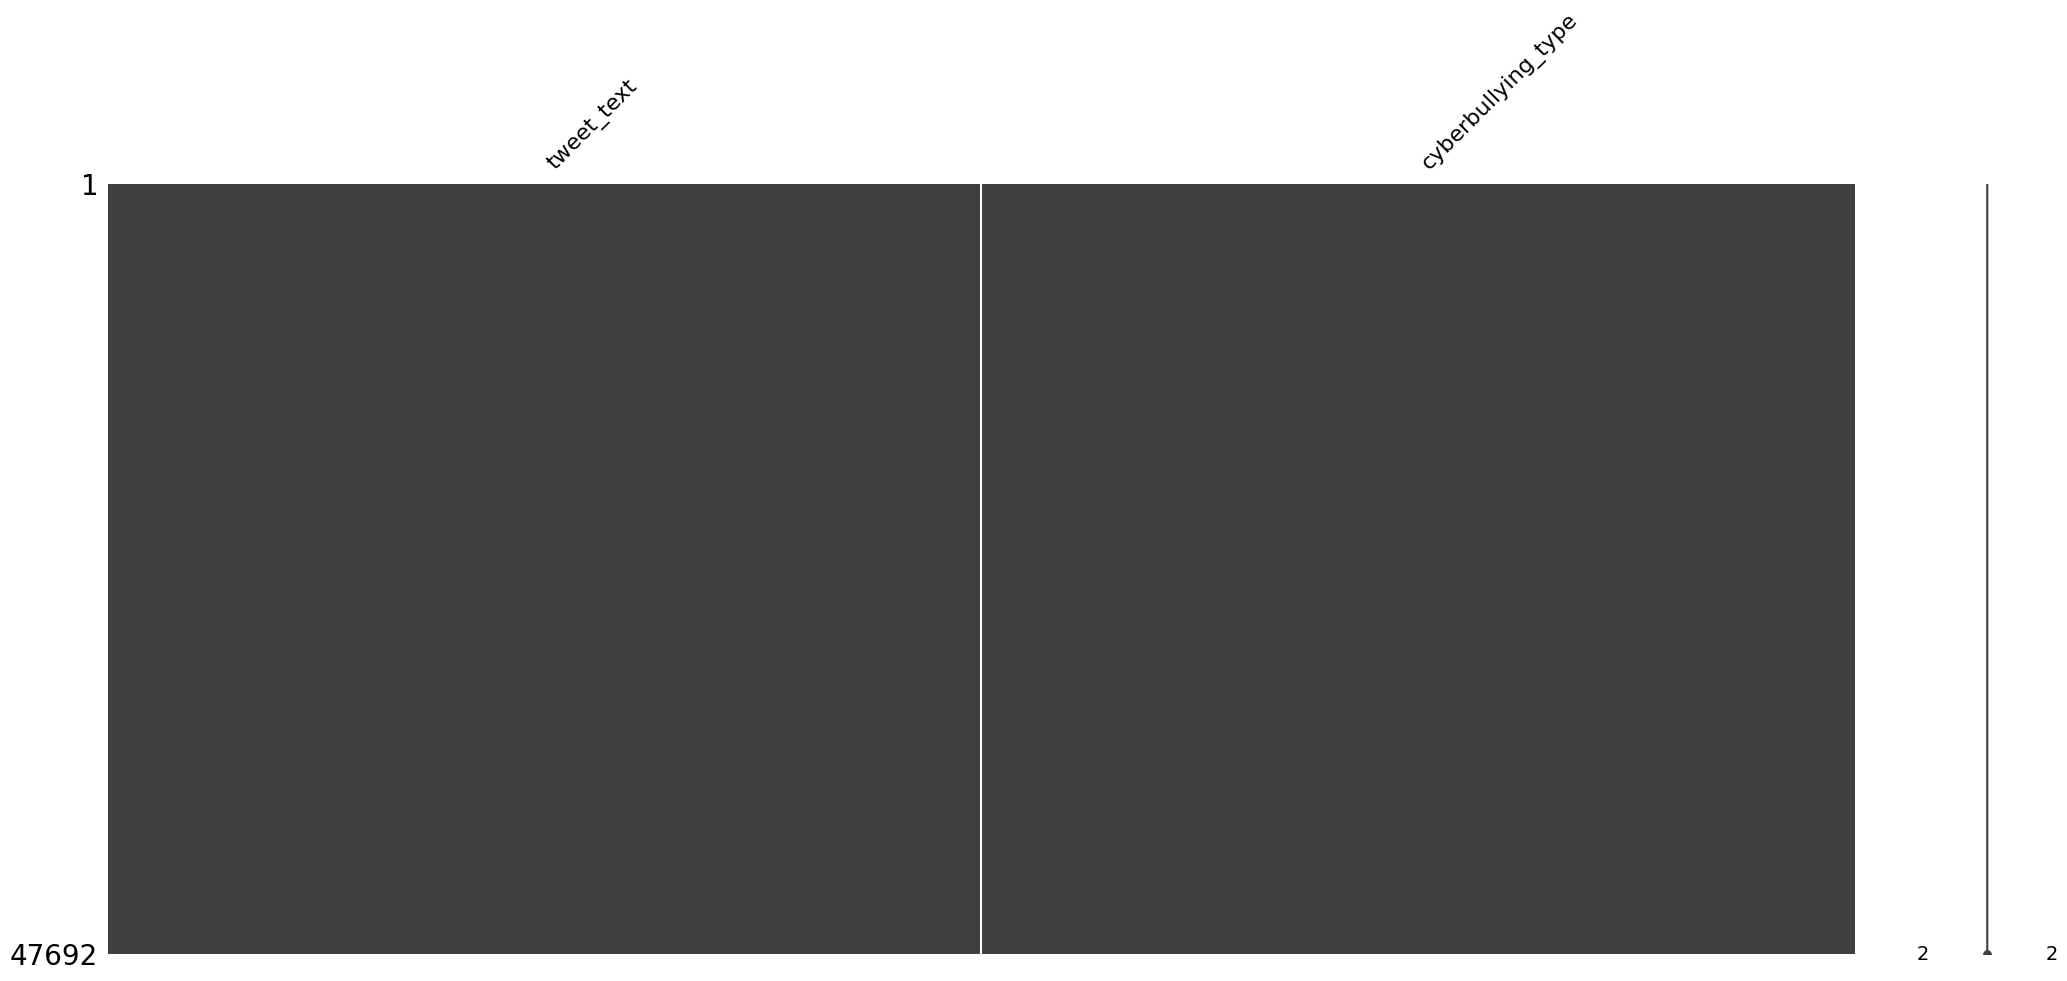

In [15]:
msno.matrix(data) #Data balance

In [16]:
data.duplicated().sum() #Duplicates

np.int64(36)

In [17]:
data.drop_duplicates(inplace=True) #Drops duplicates
data.reset_index(drop=True,inplace=True) #Resets index

In [18]:
data['cyberbullying_type'].value_counts() #Tweets distribution between classes

cyberbullying_type
religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: count, dtype: int64

In [19]:
data.describe() # Important and unique values

tweet_text cyberbullying_type
count                                               47656              47656
unique                                              46017                  6
top     Leave it to GG to think women need to compete ...           religion
freq                                                    2               7997

In [20]:
cuenta = data["tweet_text"].value_counts() #Counts unique values
print(f'Hay {len(cuenta[cuenta>=2])} tweets dobles.') # Amount of repeated tweets

Hay 1639 tweets dobles.


In [21]:
repetidos = cuenta[cuenta>=2].index # Object with the index of tweets with 2 or more ocurrencies
duplicados = data[data["tweet_text"].isin(repetidos)]# Filters the DF with the repeated
tipos = duplicados["cyberbullying_type"].value_counts() #Filters the DF w/type of CB
print(tipos)

cyberbullying_type
other_cyberbullying    1580
not_cyberbullying      1509
gender                  176
ethnicity                 7
religion                  6
Name: count, dtype: int64


In [22]:
grouped = duplicados.groupby('tweet_text')['cyberbullying_type'].unique() # Groups by cyberbullying type
grouped = grouped.reset_index() # Convert to DF
grouped.columns = ['tweet_text', 'cyberbullying_types'] # With column names
grouped[-10:]

tweet_text  \
1629      vomit. #stopwadhwa2015 http://t.co/78tLSv56cs   
1630          wadhwa is now blaming npr for bad health.   
1631    why is their whole menu dick related?!?!?! #MKR   
1632  yes i turned on profanity filter because i'm t...   
1633  yesssssssss https://t.co/SwnavDvwzD  @lukemcki...   
1634  you know, that's an interesting idea. Maybe I ...   
1635  your face is awful. @DarkSim7 @InvisibleJimBSH...   
1636  ~10% of the posts I've read on Facebook today ...   
1637  “@BurrawongGaian: @Le_bon_vivant_ @ConjurupFoo...   
1638  “The Fat Girl Behind the Fitness App” by @naom...   

                           cyberbullying_types  
1629  [not_cyberbullying, other_cyberbullying]  
1630  [not_cyberbullying, other_cyberbullying]  
1631  [not_cyberbullying, other_cyberbullying]  
1632  [not_cyberbullying, other_cyberbullying]  
1633  [not_cyberbullying, other_cyberbullying]  
1634  [not_cyberbullying, other_cyberbullying]  
1635  [not_cyberbullying, other_cyberbullying]  
1636  [not_cyberbullying, other_cyberbullying]  
1637  [not_cyberbullying, other_cyberbullying]  
1638               [not_cyberbullying, gender]

In [23]:
# Drops ambiguous entries
conflict_mask = (data.groupby('tweet_text')['cyberbullying_type'].transform('nunique') > 1)
data = data[~conflict_mask].reset_index(drop=True)

In [24]:
data.shape

(44378, 2)

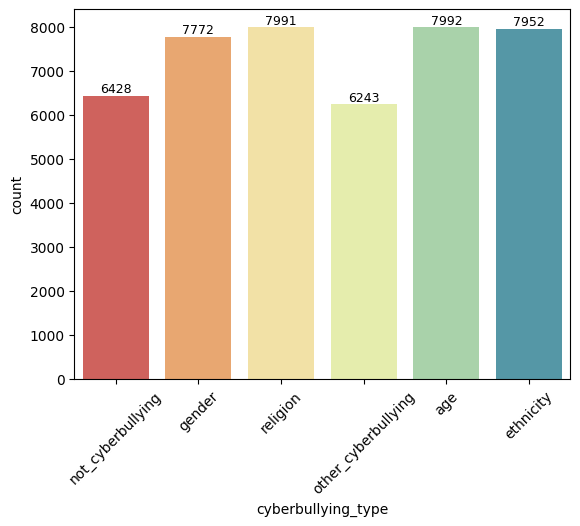

In [25]:
#Graphic of distribution of type of CB
ax= sns.countplot(data=data,x='cyberbullying_type', hue='cyberbullying_type', palette='Spectral', legend=False)
plt.xticks(rotation=45)

for container in ax.containers: # Values of each bar
    ax.bar_label(container, label_type='edge', fontsize=9)
plt.show()

## Wordcloud - Histograma de barras

In [47]:
# Preprocessing
lemmatizer = WordNetLemmatizer() # Creates lemmatizer

def get_wordnet_pos(tag): # Map POS tags to WordNet format
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

def lemmatizer_words(text): # Creates function to tokenize and lemmatize
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens) #Part-of-speech tag
    lemmatized = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(tag)) for word, tag in tagged]
    return " ".join(lemmatized)

data['tweet_text']=data['tweet_text'].astype(str) # Turns object type to string type
data['tweet_text']=data['tweet_text'].apply(lambda text: lemmatizer_words(text)) # Lambda function to lemmatize a specific column

# Creates and combine a list of special stop words
stopwords_especiales = ['rt', 'just', 'don', 'http', 'got', 'https', 'wa', 'amp', 've', 'mkr'] # List of domain-specific stop words
comb_stopwords = list(ENGLISH_STOP_WORDS.union(stopwords_especiales)) #Combine stop words

### Género

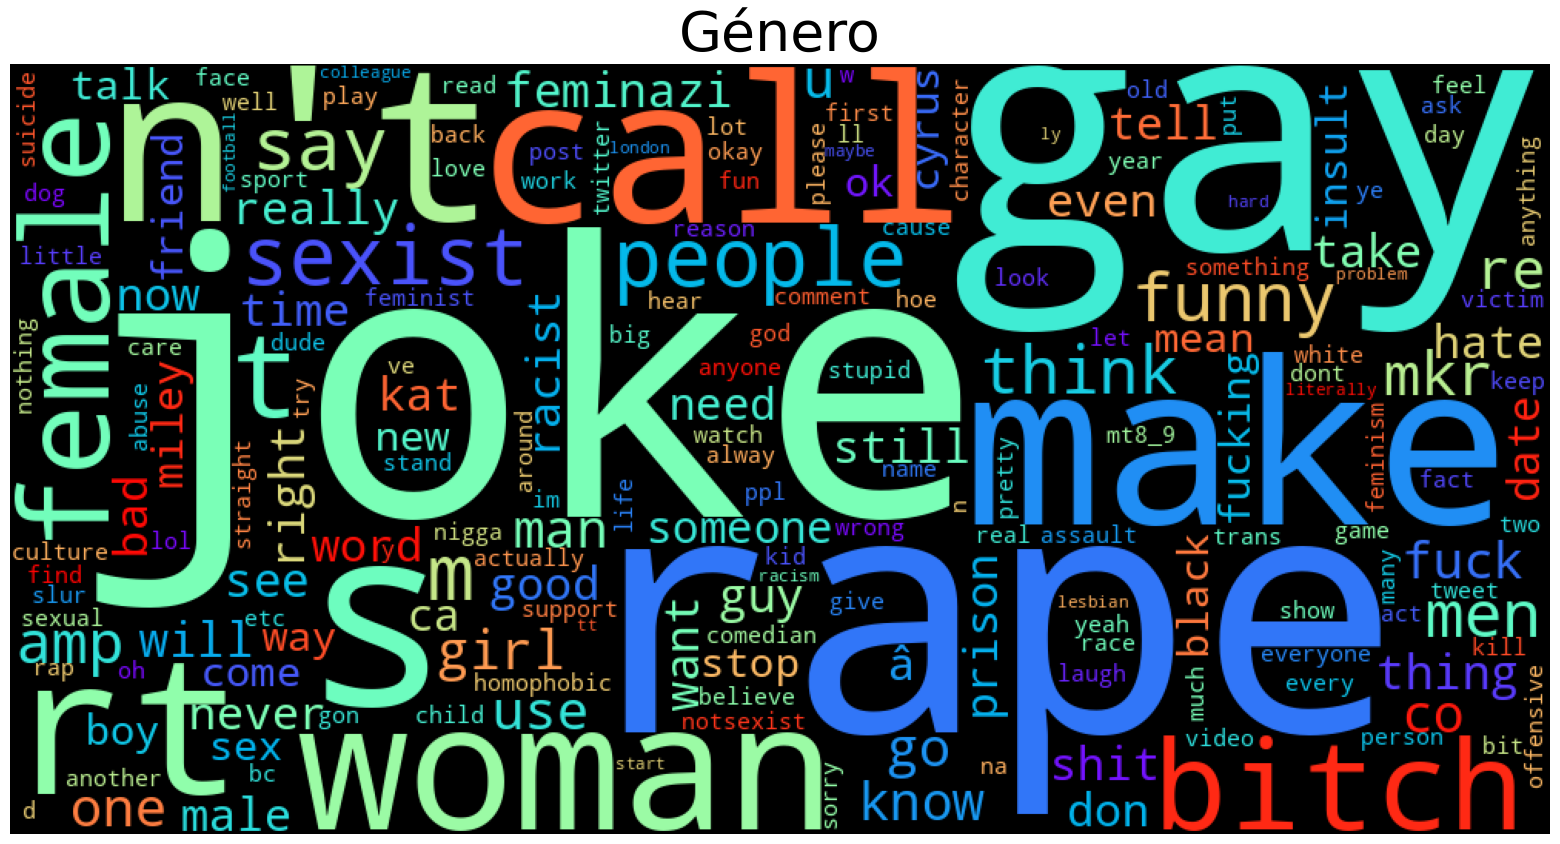

In [33]:
# Wordcloud of gender class CB
plt.figure(figsize=(20,10))
subset1 = data[data['cyberbullying_type']=='gender']
texto_genero = subset1.tweet_text.values
texto_genero = texto_genero.tolist()
cloud_genero=WordCloud(background_color='black',colormap="rainbow",collocations=False, width=1000,height=500).generate(" ".join(texto_genero))

plt.axis('off')
plt.title("Género",fontsize=40)
plt.imshow(cloud_genero)

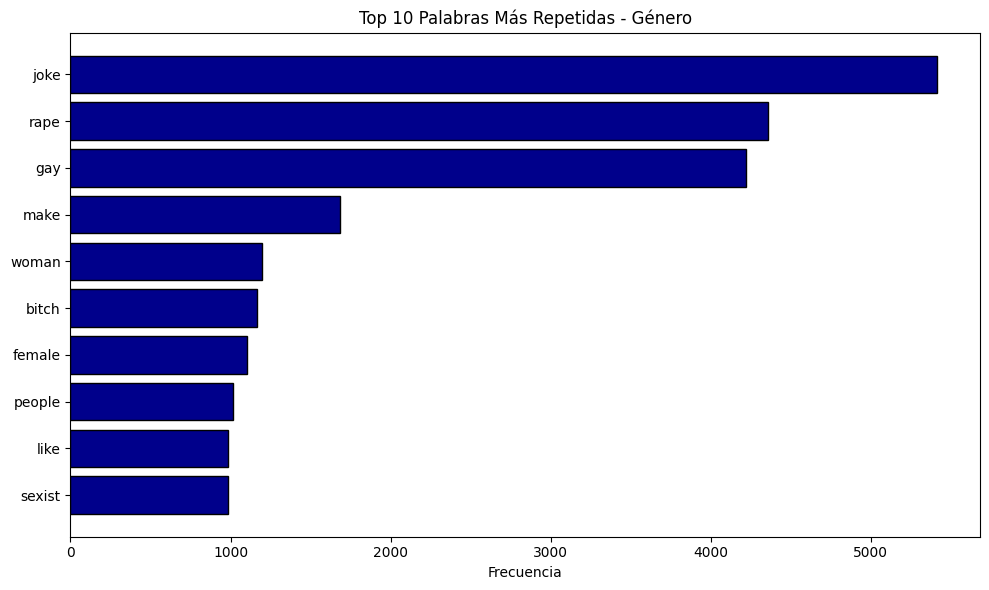

In [34]:
# Top 10 words of gender CB
def top_words(texto, top_k=10): # Defines function to retrieve the top 10 most common words
    vectorizer = CountVectorizer(stop_words=comb_stopwords) # Vectorizer with stop words removal
    X = vectorizer.fit_transform(texto)
    word_counts = X.toarray().sum(axis=0) # Word counts
    vocab = vectorizer.get_feature_names_out() # Gets the vocabulary
    word_freq = pd.DataFrame({'word': vocab, 'count': word_counts}) # Map words to their counts
    top_words = word_freq.sort_values(by='count', ascending=False).head(top_k) # Gets top k words

    return top_words

top_10_genero = top_words(texto_genero, top_k=10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_genero['word'][::-1], top_10_genero['count'][::-1], color='darkblue', edgecolor='black')
plt.xlabel('Frecuencia')
plt.title('Top 10 Palabras Más Repetidas - Género')
plt.tight_layout()
plt.show()

### Edad

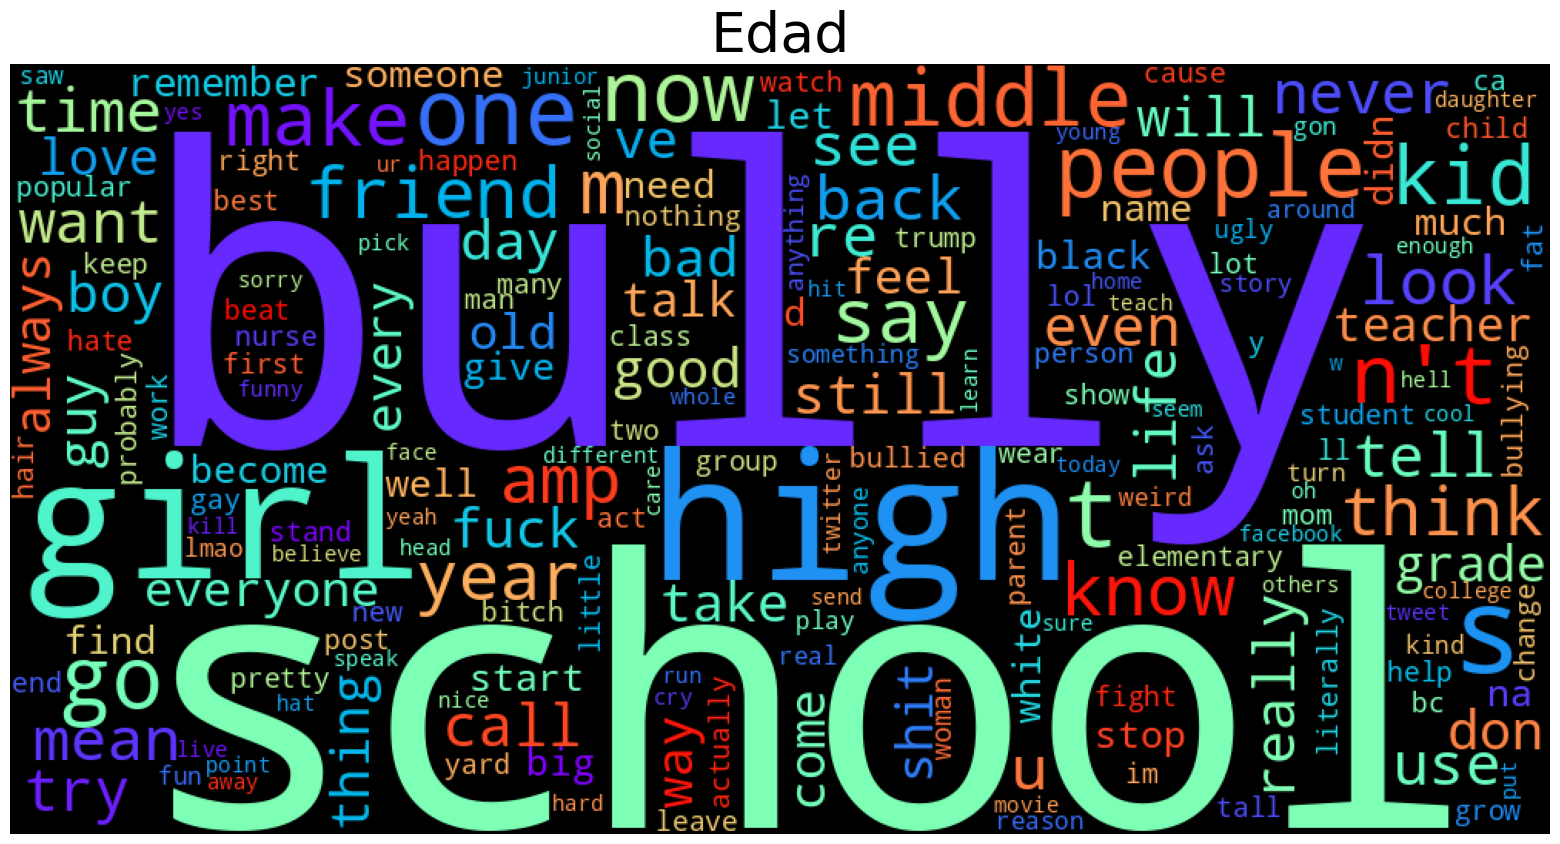

In [35]:
# Wordcloud of age class CB
plt.figure(figsize=(20,10))
subset2 = data[data['cyberbullying_type']=='age']
texto_edad = subset2.tweet_text.values
texto_edad = texto_edad.tolist()
cloud_edad=WordCloud(background_color='black',colormap="rainbow",collocations=False, width=1000,height=500).generate(" ".join(texto_edad))

plt.axis('off')
plt.title("Edad",fontsize=40)
plt.imshow(cloud_edad)

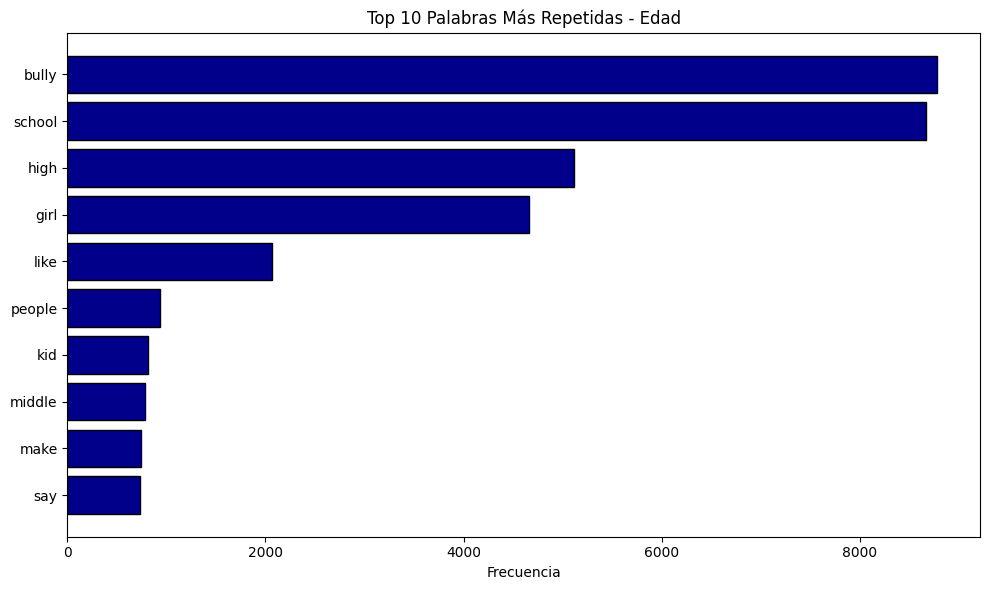

In [36]:
# Top 10 words of age CB
top_10_edad = top_words(texto_edad, top_k=10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_edad['word'][::-1], top_10_edad['count'][::-1], color='darkblue', edgecolor='black')
plt.xlabel('Frecuencia')
plt.title('Top 10 Palabras Más Repetidas - Edad')
plt.tight_layout()
plt.show()

### Religión

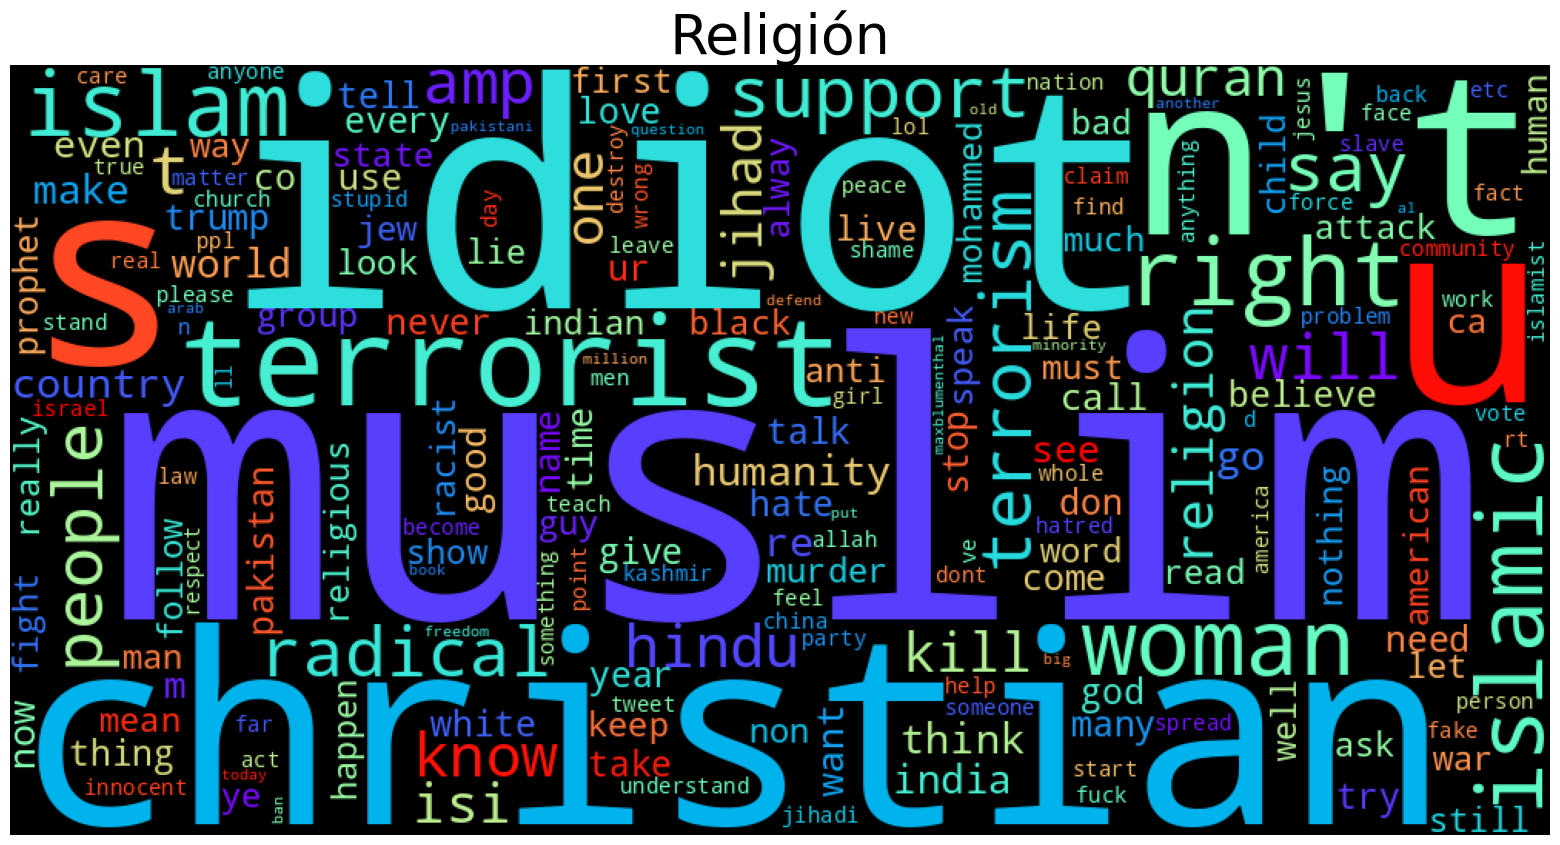

In [37]:
# Wordcloud of religion class CB
plt.figure(figsize=(20,10))
subset3 = data[data['cyberbullying_type']=='religion']
texto_reli = subset3.tweet_text.values
texto_reli = texto_reli.tolist()
cloud_reli=WordCloud(background_color='black',colormap="rainbow",collocations=False, width=1000,height=500).generate(" ".join(texto_reli))

plt.axis('off')
plt.title("Religión",fontsize=40)
plt.imshow(cloud_reli)

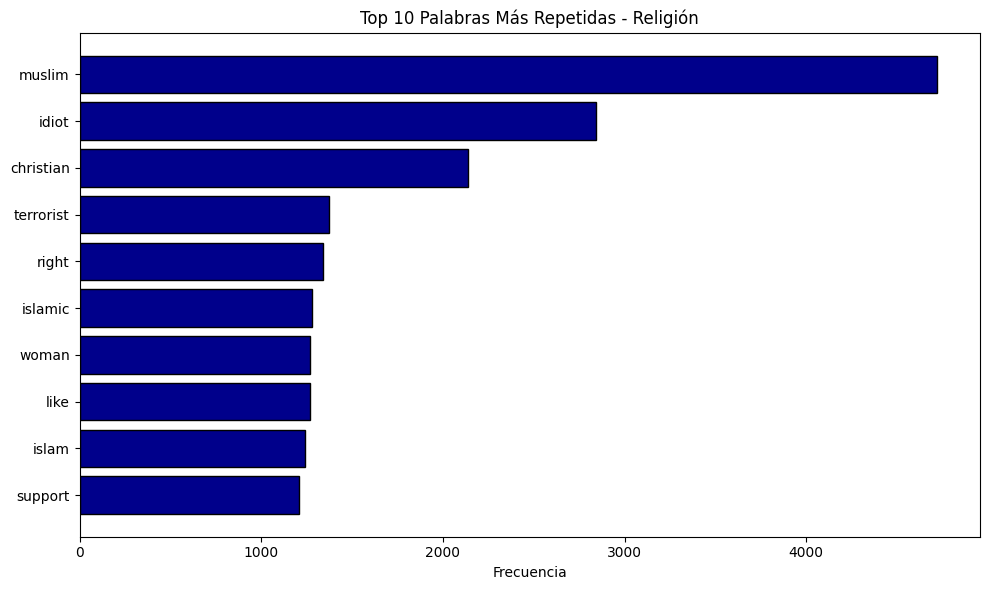

In [38]:
# Top 10 words of religion CB
top_10_reli = top_words(texto_reli, top_k=10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_reli['word'][::-1], top_10_reli['count'][::-1], color='darkblue', edgecolor='black')
plt.xlabel('Frecuencia')
plt.title('Top 10 Palabras Más Repetidas - Religión')
plt.tight_layout()
plt.show()

### Raza

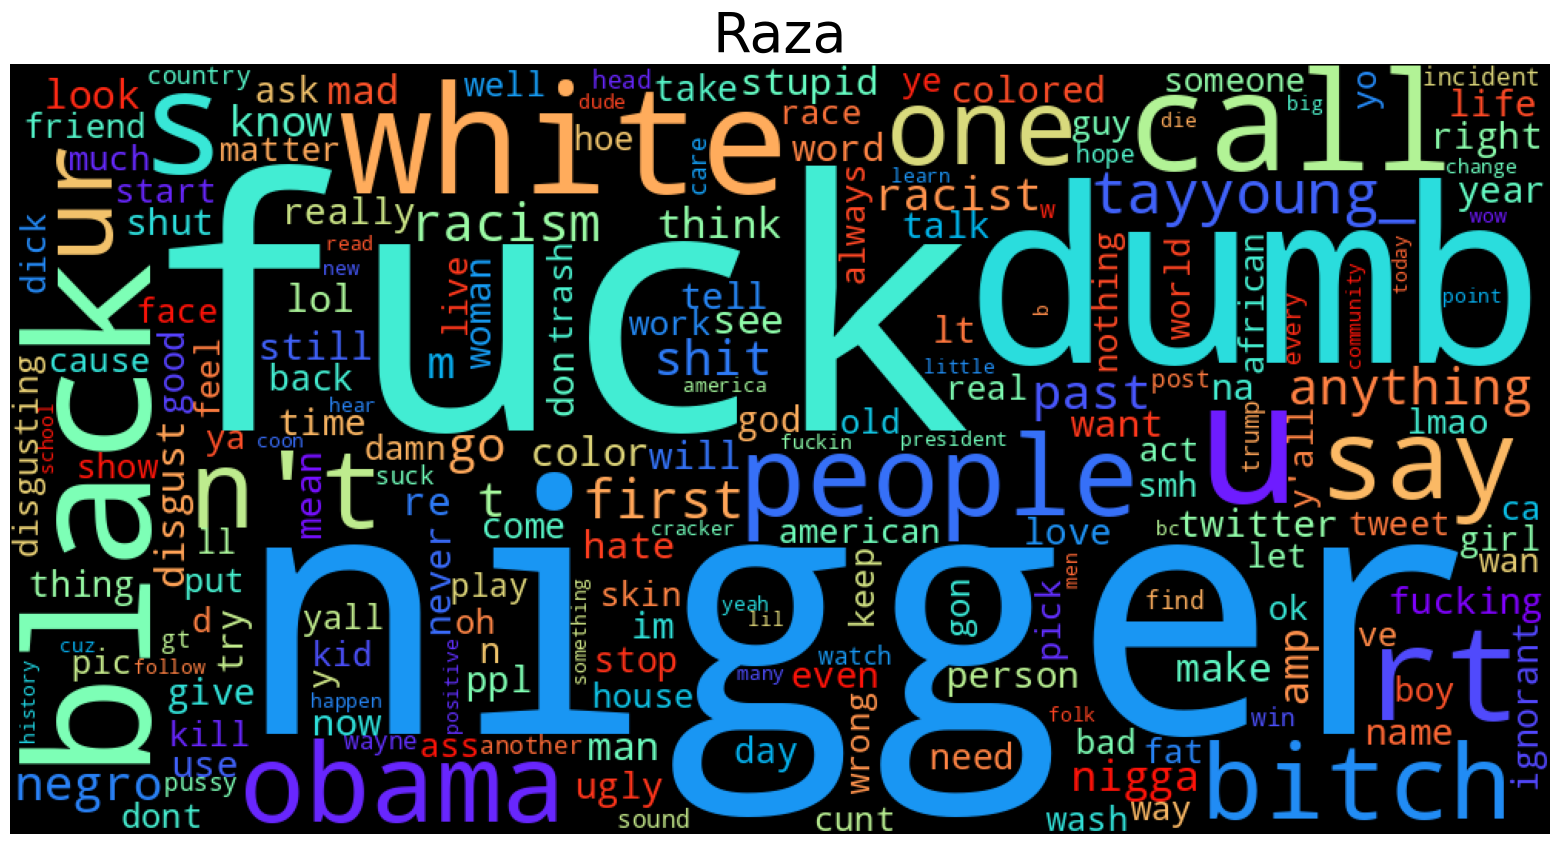

In [39]:
# Wordcloud of ethnicity class CB
plt.figure(figsize=(20,10))
subset4 = data[data['cyberbullying_type']=='ethnicity']
texto_raza = subset4.tweet_text.values
texto_raza = texto_raza.tolist()
cloud_raza = WordCloud(background_color='black',colormap="rainbow",collocations=False, width=1000,height=500).generate(" ".join(texto_raza))

plt.axis('off')
plt.title("Raza",fontsize=40)
plt.imshow(cloud_raza)

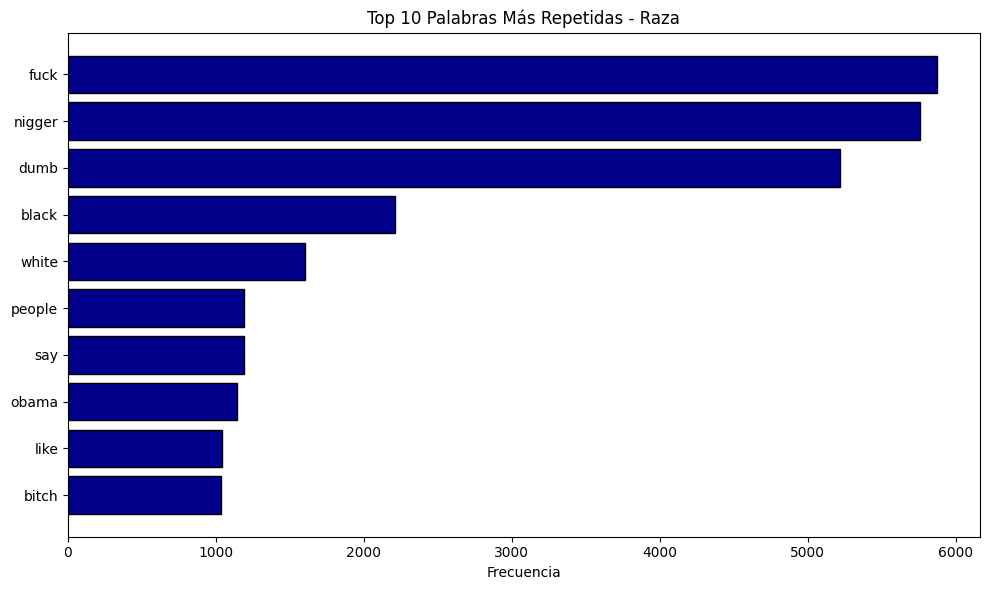

In [40]:
# Top 10 words of ethnicity CB
top_10_raza = top_words(texto_raza, top_k=10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_raza['word'][::-1], top_10_raza['count'][::-1], color='darkblue', edgecolor='black')
plt.xlabel('Frecuencia')
plt.title('Top 10 Palabras Más Repetidas - Raza')
plt.tight_layout()
plt.show()

### Otro tipo de ciberacoso

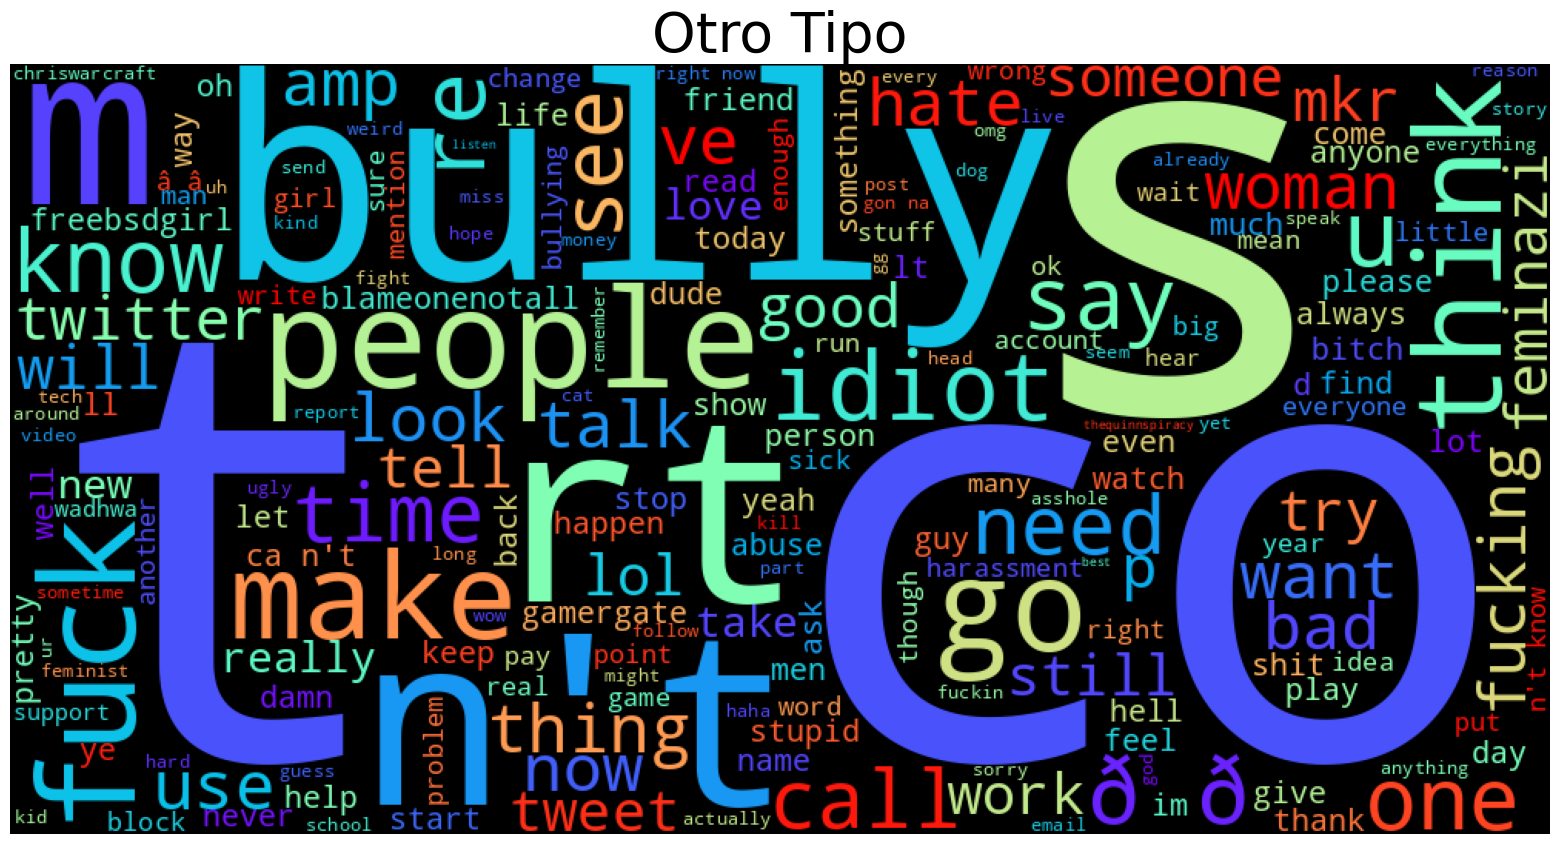

In [41]:
# Wordcloud of other CB
plt.figure(figsize=(20,10))
subset5 = data[data['cyberbullying_type']=='other_cyberbullying']
texto_otro = subset5.tweet_text.values
texto_otro = texto_otro.tolist()
cloud_otro =WordCloud(background_color='black',colormap="rainbow", collocations=True, width=1000,height=500).generate(" ".join(texto_otro))

plt.axis('off')
plt.title("Otro Tipo",fontsize=40)
plt.imshow(cloud_otro)

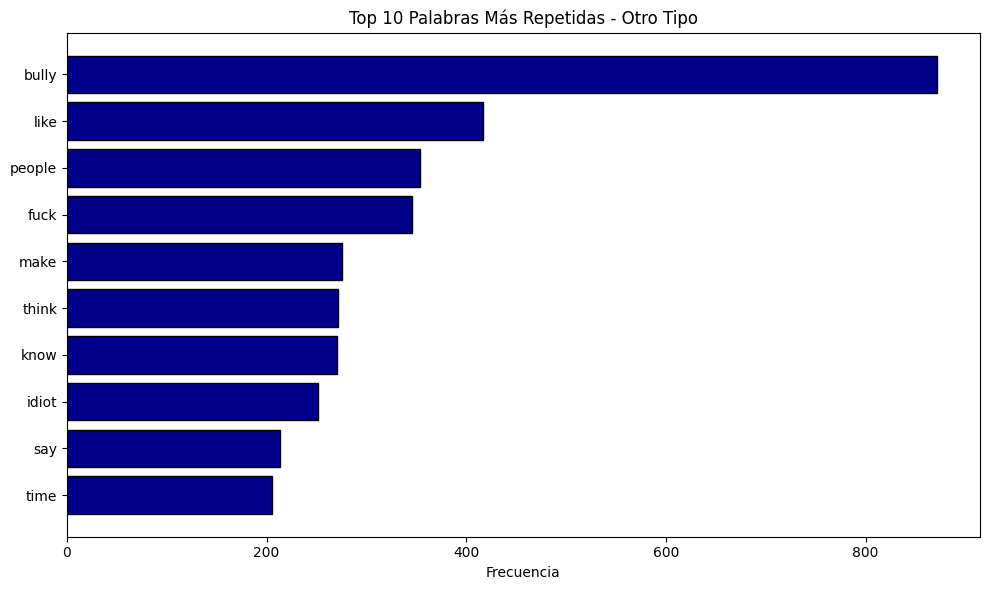

In [42]:
# Top 10 words of other CB
top_10_otro = top_words(texto_otro, top_k=10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_otro['word'][::-1], top_10_otro['count'][::-1], color='darkblue', edgecolor='black')
plt.xlabel('Frecuencia')
plt.title('Top 10 Palabras Más Repetidas - Otro Tipo')
plt.tight_layout()
plt.show()

### No Ciberacoso

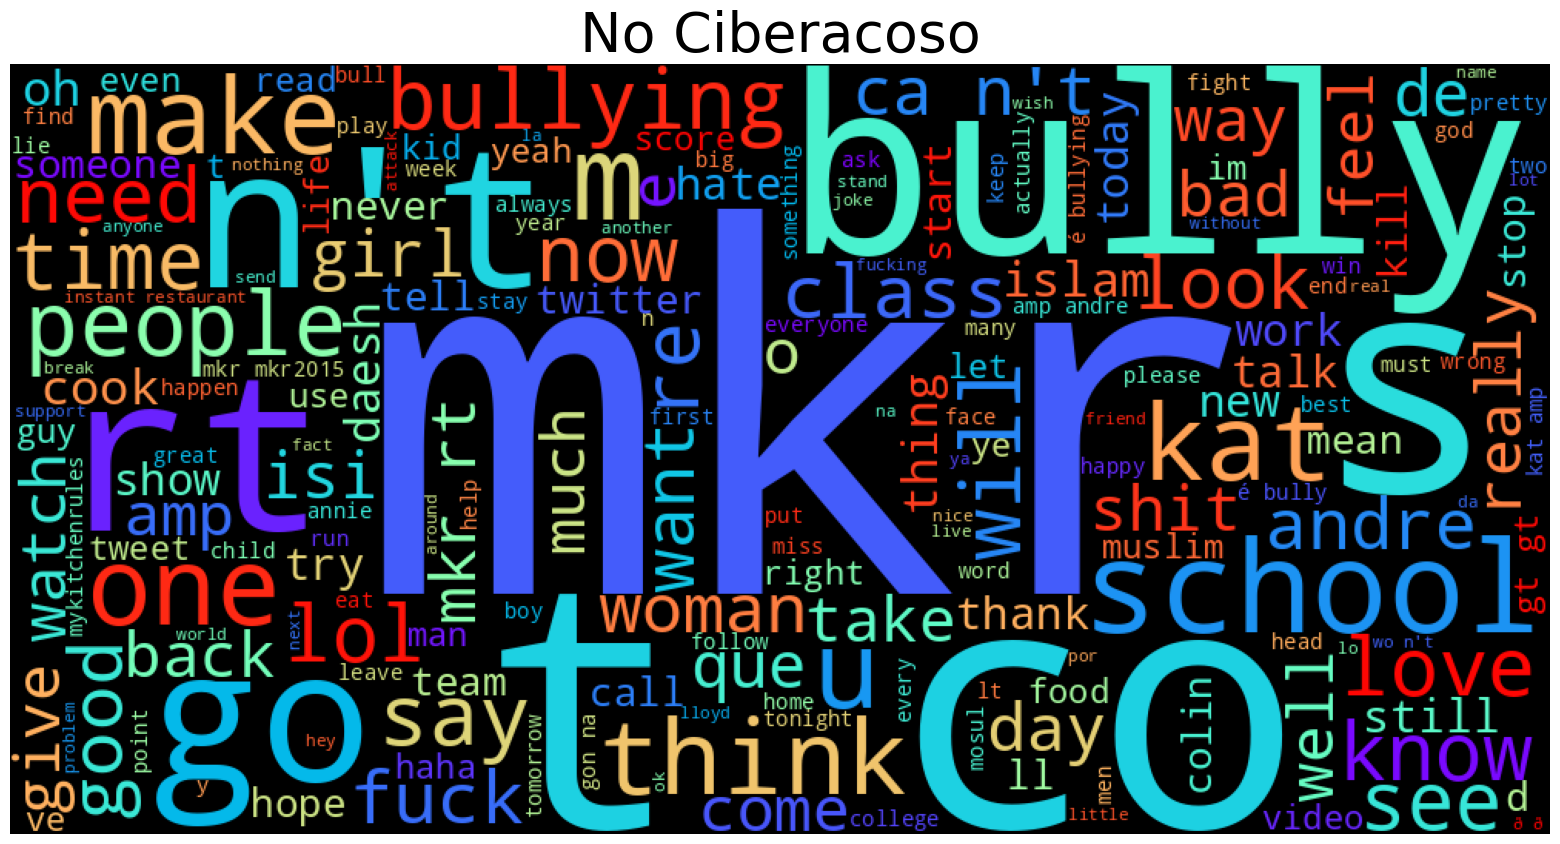

In [43]:
# Wordcloud of no CB
plt.figure(figsize=(20,10))
subset6 = data[data['cyberbullying_type']=='not_cyberbullying']
texto_no = subset6.tweet_text.values
texto_no = texto_no.tolist()
cloud_no =WordCloud(background_color='black',colormap="rainbow", collocations=True, width=1000,height=500).generate(" ".join(texto_no))

plt.axis('off')
plt.title("No Ciberacoso",fontsize=40)
plt.imshow(cloud_no)

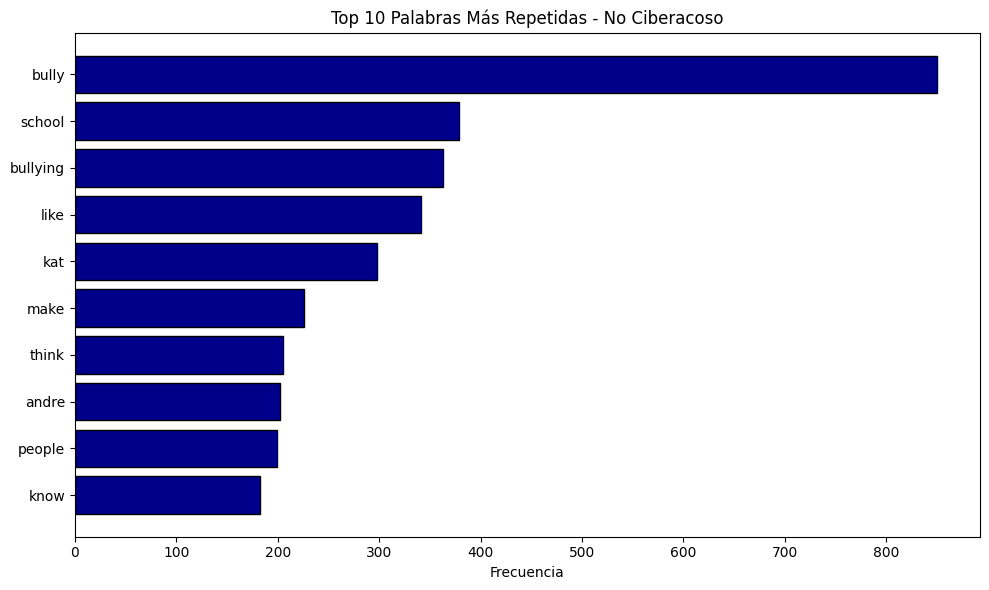

In [44]:
# Top 10 words of no CB
top_10_no = top_words(texto_no, top_k=10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_no['word'][::-1], top_10_no['count'][::-1], color='darkblue', edgecolor='black')
plt.xlabel('Frecuencia')
plt.title('Top 10 Palabras Más Repetidas - No Ciberacoso')
plt.tight_layout()
plt.show()

##Preprocesamiento y Extracción de Características

In [123]:
# Encodes labels to integers
data_copy = data.copy()
labels = data['cyberbullying_type']
encoder = LabelEncoder() # Initialize encoder
data_copy.cyberbullying_type = encoder.fit_transform(data_copy.cyberbullying_type)

In [104]:
#Train - test split (avoids data leakage)
x_train, x_test, y_train, y_test = train_test_split(data_copy['tweet_text'], data_copy['cyberbullying_type'], test_size=0.2, random_state=42)

In [105]:
# Defines a function that pre process the data and vectorize it
def vectoriza(data):
    cleaned_docs = []
    for doc in data:
        sin_emojis = emoji.replace_emoji(doc, replace="")
        no_punct = re.sub(r'[^\w\s]', '', sin_emojis)
        no_digits = re.sub(r'\d+', '', no_punct)
        cleaned_docs.append(no_digits)

    tfidf_vectorizer = TfidfVectorizer(
        max_features=5000,
        stop_words=comb_stopwords,
        token_pattern=r'(?u)\b\w\w\w+\b'
    )
    vectorizador = tfidf_vectorizer.fit_transform(cleaned_docs)
    return tfidf_vectorizer, vectorizador

vectorizer, x_train_vectorizado = vectoriza(x_train)
print(f"Número de documentos de entrenamiento: {x_train_vectorizado.shape[0]}")

Número de documentos de entrenamiento: 35502


In [106]:
y_train.value_counts() #Checks class balance

cyberbullying_type
0    6427
5    6393
1    6334
2    6249
3    5090
4    5009
Name: count, dtype: int64

In [107]:
# Class balance with SMOTE
smote = SMOTE(sampling_strategy='not majority', random_state=42)
x_train, y_train = smote.fit_resample(x_train_vectorizado, y_train)
y_train.value_counts()

cyberbullying_type
1    6427
3    6427
4    6427
2    6427
5    6427
0    6427
Name: count, dtype: int64

##Entrenamiento de Modelos

In [181]:
# Defines mlflow server
mlflow.set_tracking_uri('https://dbc-6e7a40c1-1208.cloud.databricks.com:5000')
experiment = mlflow.set_experiment('ciberacoso')

In [238]:
# Initialize and train KNN model
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train, y_train)
#mlflow.sklearn.log_model(knn, "knn_model")

KNeighborsClassifier(n_neighbors=2)

In [220]:
# Initialize and train Random Forest Model
rf = RandomForestClassifier(n_estimators=30, random_state=42)
rf.fit(x_train, y_train)
# Log the model with MLflow
#mlflow.sklearn.log_model(rf, "random_forest_model")

RandomForestClassifier(n_estimators=30, random_state=42)

##Evaluación de modelo

In [239]:
# Test data preprocessing
def transforma(data, vectorizer):
    cleaned_docs = []
    for doc in data:
        sin_emojis = emoji.replace_emoji(doc, replace="")
        no_punct = re.sub(r'[^\w\s]', '', sin_emojis)
        no_digits = re.sub(r'\d+', '', no_punct)
        cleaned_docs.append(no_digits)

    return vectorizer.transform(cleaned_docs)

x_test_vectorizado = transforma(x_test, vectorizer)
print(f"Forma de matriz de características de prueba: {x_test_vectorizado.shape}")

Forma de matriz de características de prueba: (8876, 5000)


In [240]:
# Evaluate KNN model
knn_test_pred = knn.predict(x_test_vectorizado) # Makes predictions with test data
print(classification_report(y_test, knn_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.29      0.43      1565
           1       0.81      0.61      0.70      1618
           2       0.64      0.55      0.59      1523
           3       0.24      0.71      0.36      1338
           4       0.29      0.38      0.33      1234
           5       0.97      0.10      0.19      1598

    accuracy                           0.44      8876
   macro avg       0.62      0.44      0.43      8876
weighted avg       0.65      0.44      0.44      8876



In [223]:
# Evaluate RF model
rf_test_pred = rf.predict(x_test_vectorizado)
print(classification_report(y_test, rf_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1565
           1       0.98      0.91      0.94      1618
           2       0.90      0.85      0.87      1523
           3       0.63      0.60      0.62      1338
           4       0.59      0.72      0.65      1234
           5       0.96      0.95      0.96      1598

    accuracy                           0.85      8876
   macro avg       0.84      0.83      0.83      8876
weighted avg       0.85      0.85      0.85      8876



In [128]:
# Inverse transform to get original labels
original_labels = encoder.inverse_transform(data_copy['cyberbullying_type'].unique())
print("Original Labels:", original_labels)

Original Labels: ['not_cyberbullying' 'gender' 'religion' 'other_cyberbullying' 'age'
 'ethnicity']


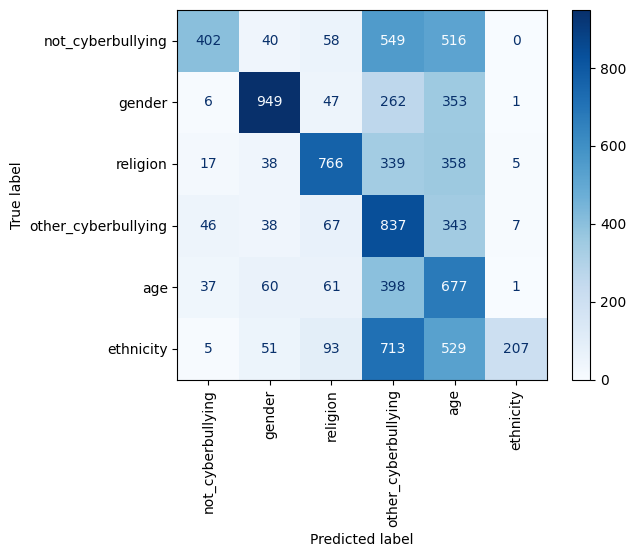

In [138]:
# Confusion matrix of KNN model
cm_knn = confusion_matrix(y_test,knn_test_pred)
ConfusionMatrixDisplay(cm_knn, display_labels=original_labels).plot(cmap='Blues', xticks_rotation='vertical')

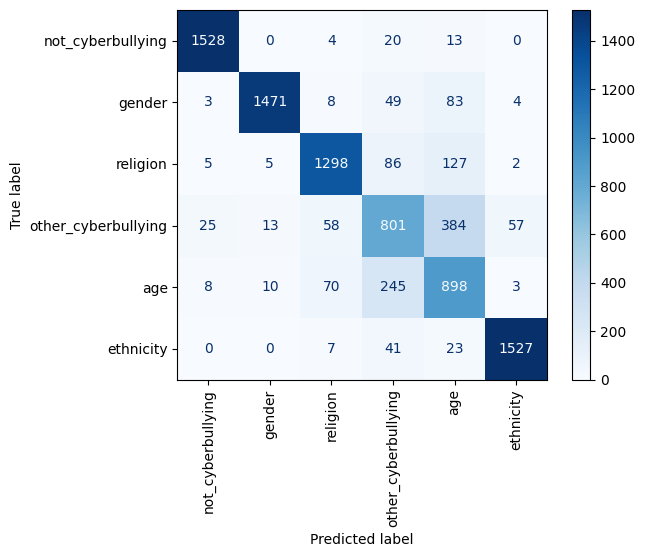

In [139]:
# Confusion matrix of RF model
cm_rf = confusion_matrix(y_test,rf_test_pred)
ConfusionMatrixDisplay(cm_rf, display_labels=original_labels).plot(cmap='Blues', xticks_rotation='vertical')

In [153]:
# Cross validation score
cv_scores_knn = cross_val_score(knn, x_train, y_train, cv=5)
cv_scores_rf = cross_val_score(rf, x_train, y_train, cv=5)

print('Cross validation score (K Nearest Neighbor):', cv_scores_knn.mean())
print('Cross validation score (Random Forest Classifier):', cv_scores_rf.mean())

Cross validation score (K Nearest Neighbor): 0.4503135905699974
Cross validation score (Random Forest Classifier): 0.8625593752908409


In [241]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
estimators = [('knn', KNeighborsClassifier(n_neighbors=2)), ('rf', RandomForestClassifier(n_estimators=30, random_state=42))]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(x_train, y_train).score(x_test_vectorizado, y_test)

0.8454258675078864